# Laplacian Associative Memory (LAM) - ALPHA

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from nn import LAM
import libtools

---

#### DATA

In [4]:
# src = libtools.preference_map(16, 25, 200)
src = np.load('../data/mat/SOM_orient_v1.npy')
src = libtools.downsample(src, 4)

print('Map:', src.shape)
print('min:', f"{src.min():.2f}", 'max:', f"{src.max():.2f}")

Map: (50, 50)
min: 0.00 max: 6.28


---

### HYPER-PARAMETERS

In [5]:
N = 8192                                # Neurons | Default: 30000
prob = 0.1                              # Sparsity
eta = 0.01                              # Epsilon / Learning rate
simlen = 3000                           # Steps / Epochs
gamma = 0.6                             # Inhibition ratio
norm_mode = 'asym'                      # Asymmetric Normalisation
P = src.shape[0] * src.shape[1]         # N Nodes

sigmaX = 0.001                          # Spatial Gaussian Scale
sigmaA = 0.1                            # Angular Gaussian Scale

temp = 0.0215                           # Activation Probability

# Init condition (Center cell/pixel)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))

print('Neurons:', N)
print("Nodes:", P)
print('Start node:', start_node)
print(f"{P * 0.138:.2f} point attactors")

Neurons: 8192
Nodes: 2500
Start node: 1275
345.00 point attactors


---

### COMPUTE | ALPHA

In [6]:
a_arr = np.arange(-1.0, 1.1, 0.1) # Alpha

In [7]:
a_hist, m_hist = [],[]

for i in tqdm(range(len(a_arr))):
    a = np.around(a_arr[i], decimals=1)
    W = libtools.construct_SLAM(src, sigmaX, sigmaA)

    graph = LAM(N, P, prob, W, gamma, "asym", start_node)
    graph._set_weight(a_arr[i])
    
    m_log, _, e_log = graph.simulate_single(a_arr[i], eta, simlen)
    m = m_log[-1,:].copy()

    a_hist.append(a)
    m_hist.append(m)

100%|██████████| 21/21 [42:50<00:00, 122.41s/it]


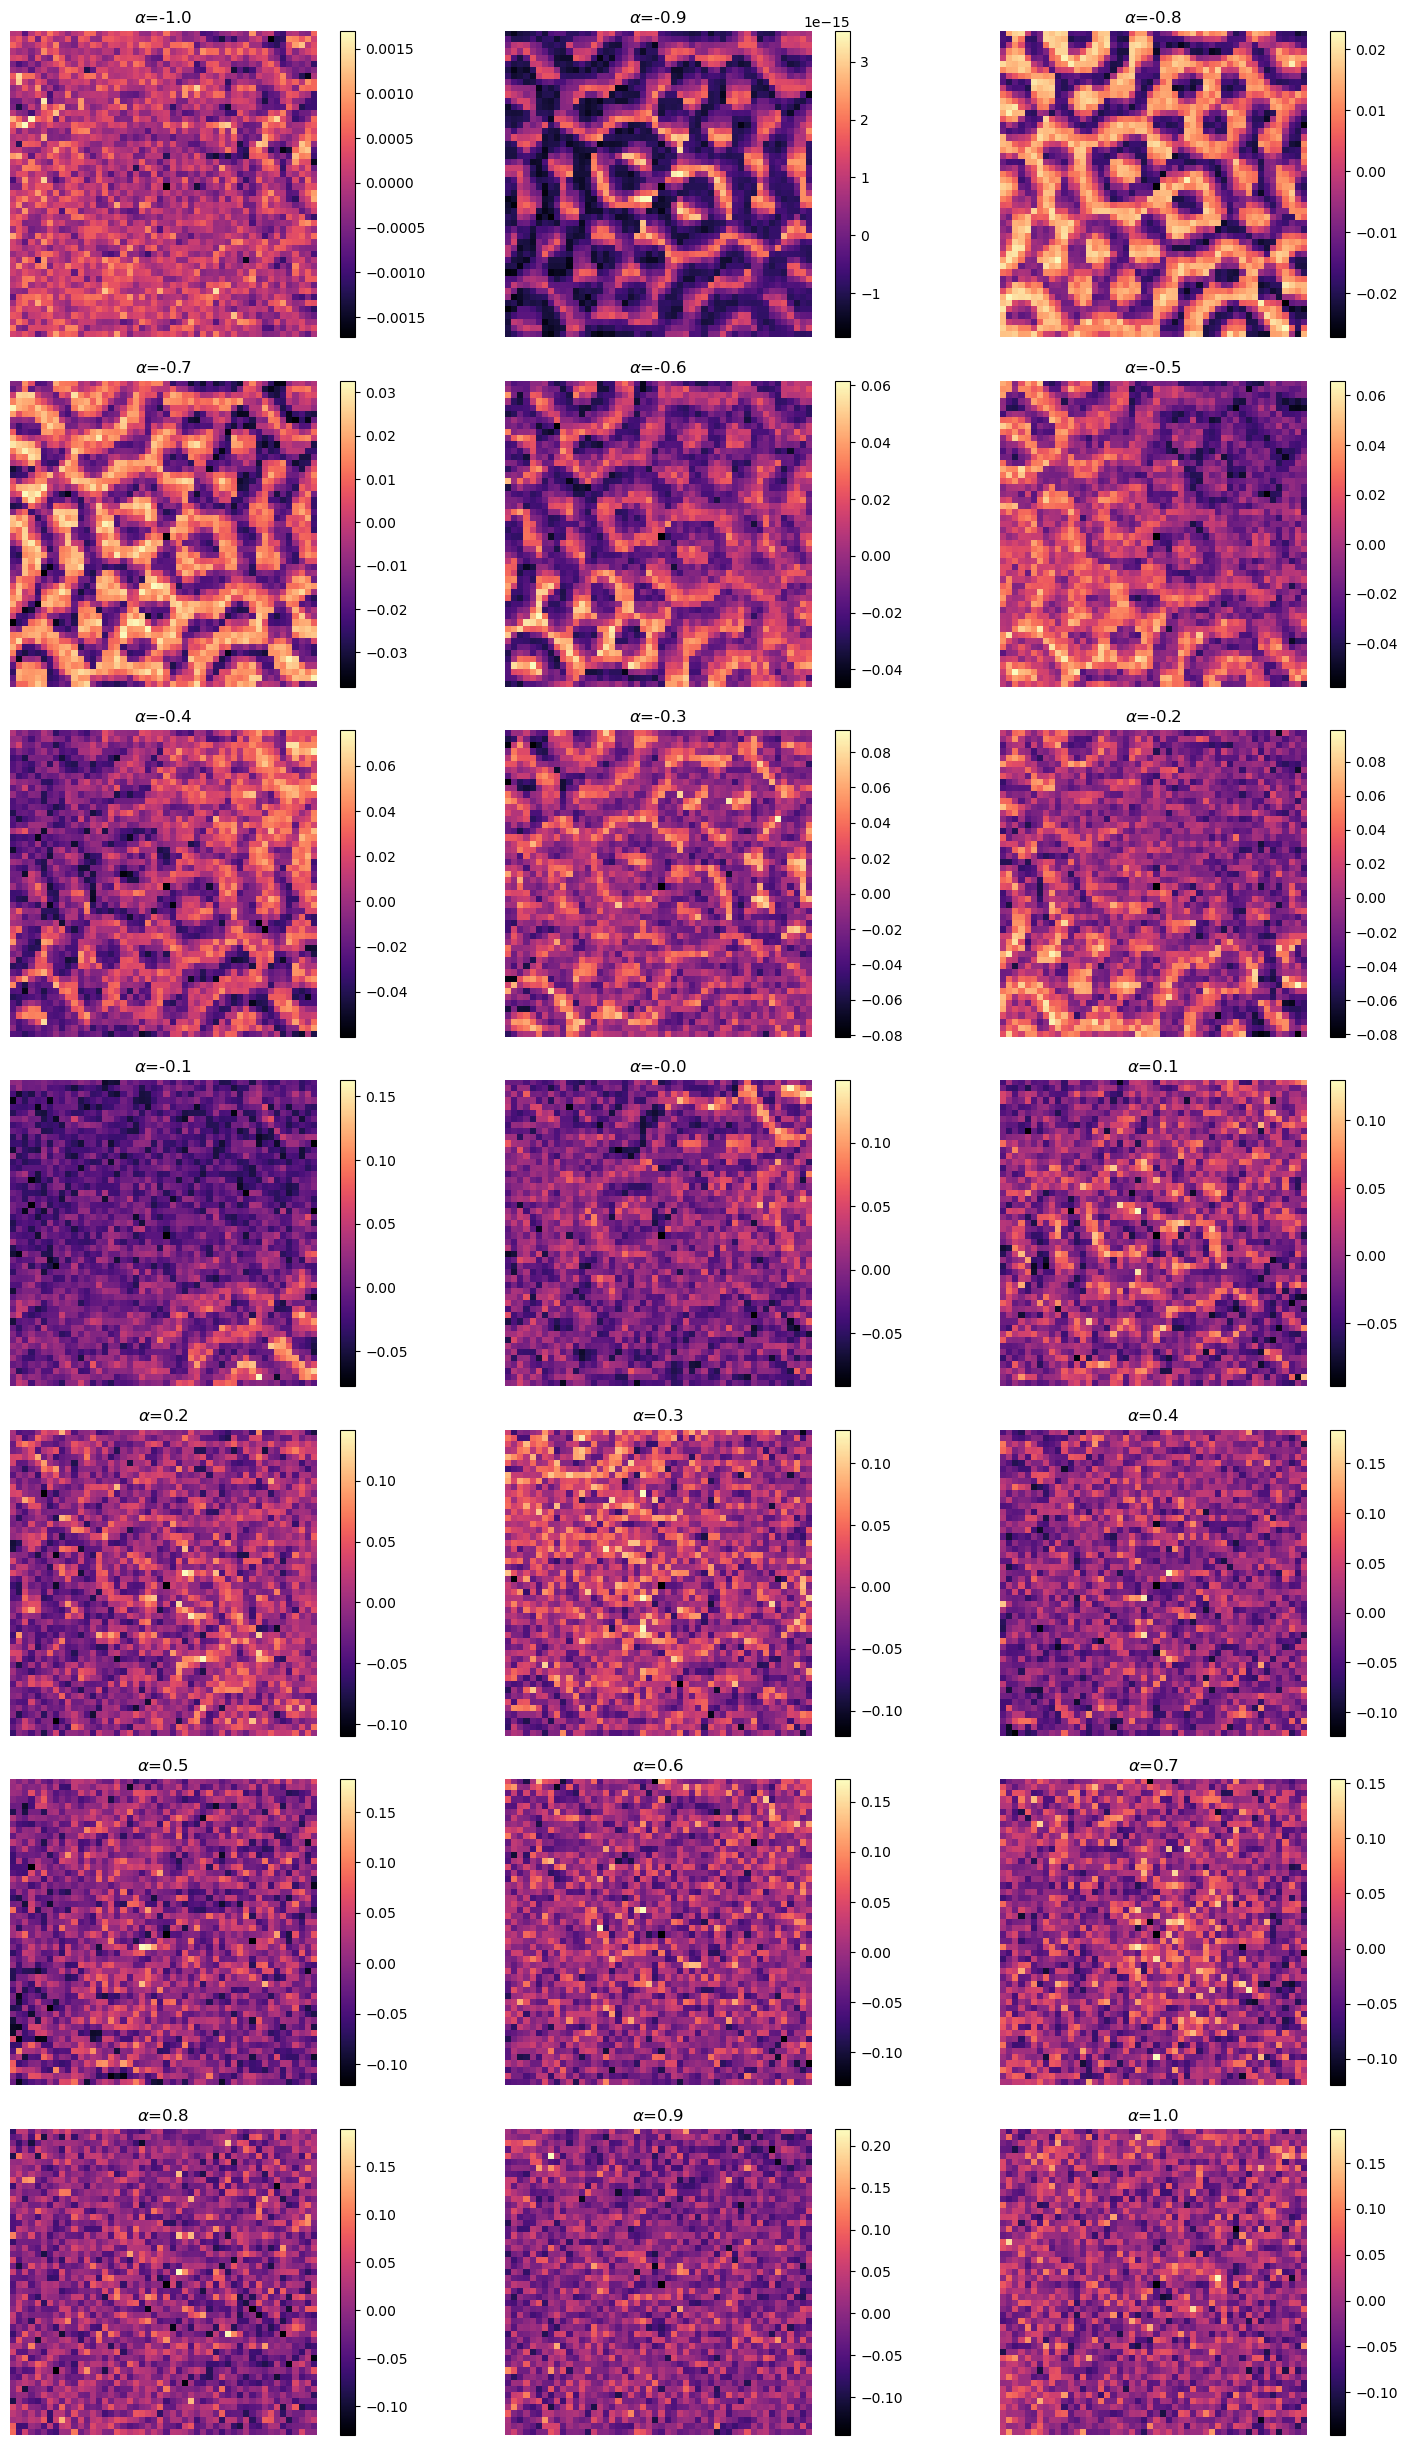

In [8]:
plt.figure(figsize=(15,70))
for a_ind in range(len(a_arr)):
    a = np.around(a_arr[a_ind], decimals=1)
    m = m_hist[a_ind]
    m[start_node] = m.min()

    plt.subplot(20, 3, a_ind+1)
    plt.imshow(m.reshape(src.shape), cmap="magma", vmin=np.min(m), vmax=np.max(m))
    plt.axis("off"), plt.colorbar()
    plt.title(r"$\alpha$="+str(a))
    plt.tight_layout()

---

In [11]:
Na = len(a_arr)
max_overlap = np.zeros(Na)
Nactive = np.zeros(Na)

for a_ind in range(Na):
    m = m_hist[a_ind]
    max_m = np.max(m)
    max_overlap[a_ind] = max_m
    Nactive[a_ind] = np.mean(np.sum((m > 0.5*max_m) * (m > 0.0), axis=0))

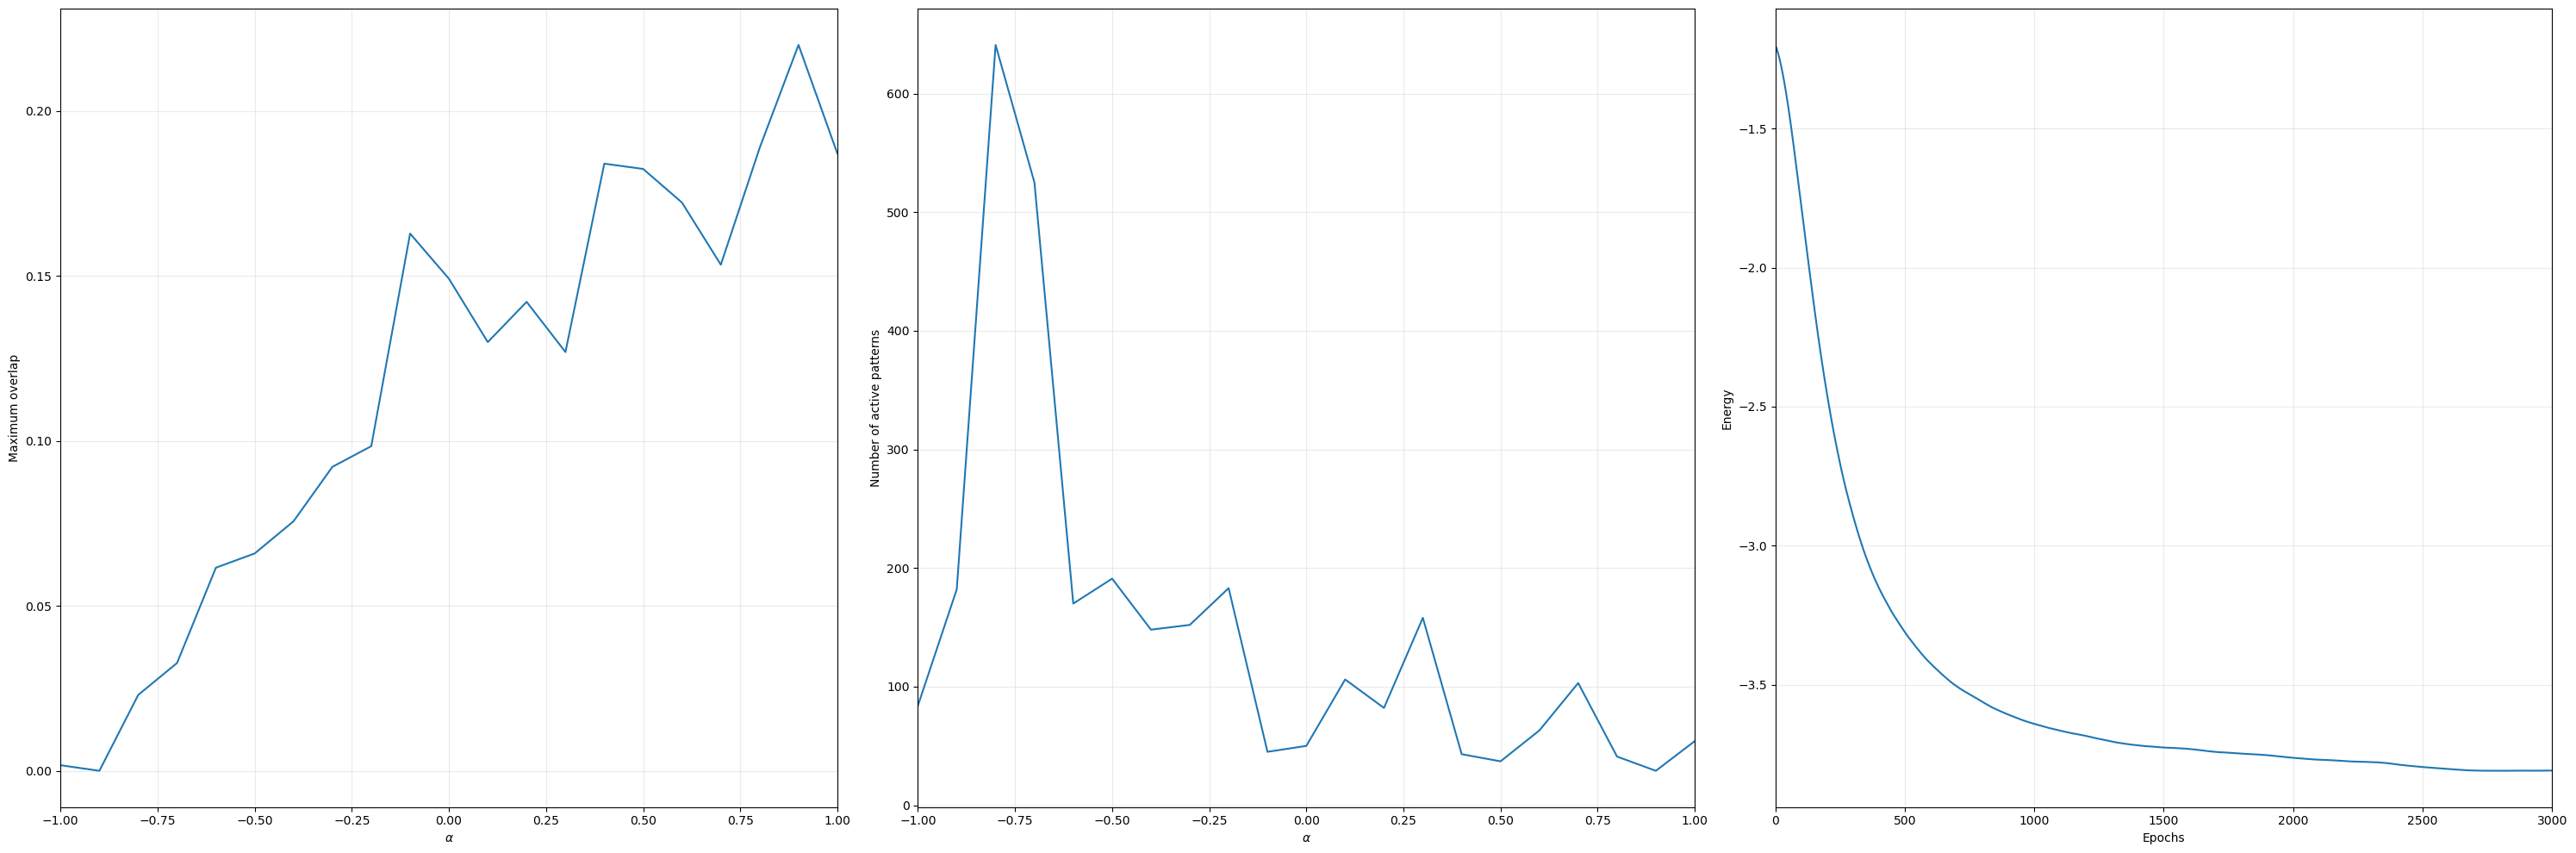

In [12]:
xlim=[np.min(a_arr), np.max(a_arr)]

# Max. overlap
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(a_arr, max_overlap)
plt.xlabel(r"$\alpha$"), plt.ylabel("Maximum overlap")
plt.xlim(xlim)
plt.grid('on', alpha=0.25)

# Number of patterns
plt.subplot(1,3,2)
plt.plot(a_arr, Nactive)
plt.xlabel(r"$\alpha$"), plt.ylabel("Number of active patterns")
plt.xlim(xlim)
plt.grid('on', alpha=0.25)

# Energy
plt.subplot(1,3,3)
plt.plot(e_log)
plt.xlabel("Epochs"), plt.ylabel("Energy")
plt.xlim(0,simlen)
plt.grid('on', alpha=0.25)
plt.tight_layout()